In [1]:
!pip install xgboost
!pip install imblearn



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss
%matplotlib inline


from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/train_test_network.csv")


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [6]:
data.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')

In [7]:
data=data.drop_duplicates()

In [8]:
data.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
service,0
duration,0
src_bytes,0
dst_bytes,0
conn_state,0


In [9]:
data.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [10]:
data['type'].value_counts()

,count
type,
normal,42040
scanning,20000
ddos,19993
injection,19964
password,19861
dos,18992
backdoor,18711
xss,15137
ransomware,14735


In [11]:
data["label"].value_counts()

,count
label,
1,148434
0,42040


In [12]:

encoders = {}

cat_cols = ['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query',
       'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version',
       'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject',
       'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri',
       'http_version', 'http_user_agent', 'http_orig_mime_types',
       'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice',
       'type']
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders[col] = le

In [13]:
Y = data[['type','label']]
X= data.drop(["type","label"],axis=1)

In [14]:
label_mapping = dict(zip(range(len(encoders["type"].classes_)), encoders["type"].classes_))
print(label_mapping)


{0: 'backdoor', 1: 'ddos', 2: 'dos', 3: 'injection', 4: 'mitm', 5: 'normal', 6: 'password', 7: 'ransomware', 8: 'scanning', 9: 'xss'}


In [15]:
X.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice
0,26,4444,201,49178,1,0,290.371539,101568,2592,0,...,0,0,0,0,0,0,0,0,0,0
1,16,49180,210,8080,1,0,0.000102,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,16,49180,210,8080,1,0,0.000148,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,16,49180,210,8080,1,0,0.000113,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16,49180,210,8080,1,0,0.000130,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
mi_label = mutual_info_classif(X, Y["label"])
mi_type = mutual_info_classif(X, Y["type"])
mi_avg = (mi_label + mi_type ) / 2

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_label': mi_label,
    'MI_type': mi_type,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [17]:
top_features

['src_ip_bytes',
 'src_ip',
 'dst_port',
 'dst_ip_bytes',
 'src_port',
 'dst_ip',
 'conn_state',
 'duration',
 'src_bytes',
 'dst_bytes',
 'src_pkts',
 'dst_pkts',
 'service',
 'dns_query',
 'proto',
 'dns_rejected',
 'dns_RA',
 'dns_qtype',
 'dns_RD',
 'dns_AA']

In [18]:
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["label"])

model1 = XGBClassifier(tree_method='hist', n_jobs=-1)
model1.fit(X, Y["type"])



importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(15)

importances = model1.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features1 = importance_df['feature'].head(15)



combined_features = set(top_features) | set(top_features1)
X = X[list(combined_features)]

In [19]:
combined_features

{'conn_state',
 'dns_RA',
 'dns_RD',
 'dns_qtype',
 'dns_rejected',
 'dst_bytes',
 'dst_ip',
 'dst_ip_bytes',
 'dst_pkts',
 'dst_port',
 'duration',
 'proto',
 'service',
 'src_bytes',
 'src_ip',
 'src_ip_bytes',
 'src_pkts',
 'src_port'}

In [20]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [22]:
X_train.shape

(152379, 18)

In [23]:
y_train[y_train["label"]==0].shape

(33632, 2)

In [24]:
y_test[y_test["label"]==0].shape

(8408, 2)

In [25]:
y_all = y_train[['label', 'type']].reset_index(drop=True)

# Apply SMOTE to balance label = 0 (normal)
sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_label_resampled = sm.fit_resample(X_train, y_all['label'])

# Count synthetic samples
n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

# Original types (before SMOTE)
type_original = y_all['type'].iloc[:n_original].tolist()

# Get encoded value for 'Normal' from original data (you mentioned it's 5)
normal_encoded = 5

# Assign 'Normal' type (5) to all synthetic samples
synthetic_types = [normal_encoded] * n_synthetic

# Combine type and label
type_final = type_original + synthetic_types
label_final = y_label_resampled.tolist()

# Final DataFrame
y_train_resampled = pd.DataFrame({
    'type': type_final,
    'label': label_final
})

# Update X and y
X_train = X_resampled
y_train = y_train_resampled

In [26]:
y_train[y_train["label"]==0].shape

(118747, 2)

In [27]:
y_test[y_test["label"]==1].shape

(29687, 2)

In [28]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_label = RandomForestClassifier(max_depth=max_depth)
        self.rfc_type = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_label.fit(X_train,y_train['label'])

        features_type = np.concatenate((X_train,np.array(y_train['label']).reshape(-1,1)),axis=1)
        self.rfc_type.fit(features_type,y_train['type'])


    def predict(self,X_test):
        predict_label = self.rfc_label.predict(X_test)
        y_proba=self.rfc_label.predict_proba(X_test)[:,1]
        test_type = np.concatenate((X_test,predict_label.reshape(-1,1)),axis=1)
        predict_type = self.rfc_type.predict(test_type)





        return pd.DataFrame({'label':predict_label,'type':predict_type,"y_proba":y_proba})

In [29]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    # Classification report
    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])  # Skip last 3 rows for summary clarity

    # Confusion Matrix
    print("\n📊 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Basic Scores
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    # ROC, PR Curves for Binary
    if y_proba is not None:
        n_classes = pd.Series(y_true).nunique()
        if n_classes == 2:
            roc_auc = roc_auc_score(y_true, y_proba)
            pr_auc = average_precision_score(y_true, y_proba)
            print(f"📈 ROC AUC Score: {roc_auc:.4f}")
            print(f"📈 PR AUC Score: {pr_auc:.4f}")

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_true, y_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

**Random Forest**

In [30]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.992653  0.964201  0.978220   8408.0
1   0.989943  0.997979  0.993944  29687.0

📊 Confusion Matrix:


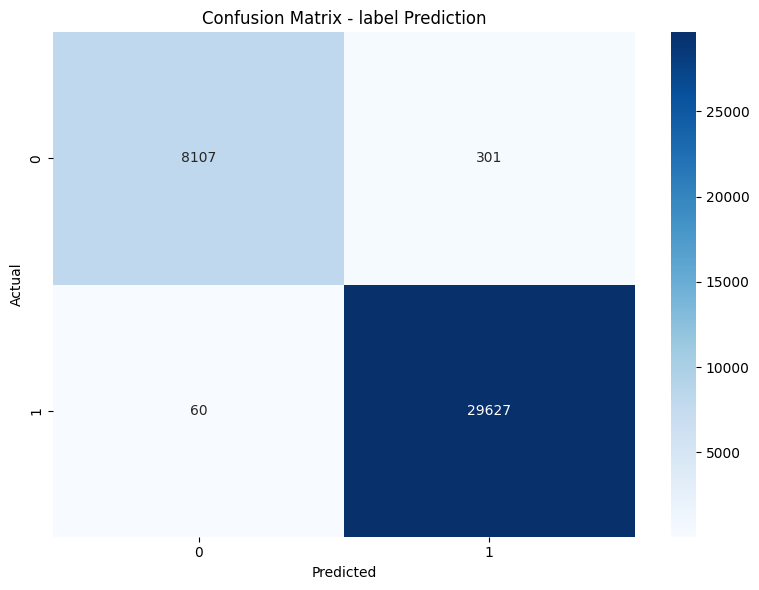


✅ Accuracy: 0.9905
✅ Weighted F1 Score: 0.9905
✅ Macro F1 Score: 0.9861
✅ Macro Precision: 0.9913
✅ Macro Recall: 0.9811
❌ Hamming Loss: 0.009476
📈 ROC AUC Score: 0.9998
📈 PR AUC Score: 0.9999


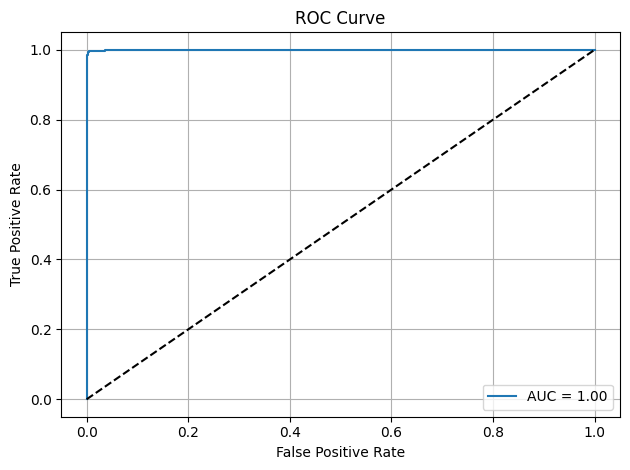

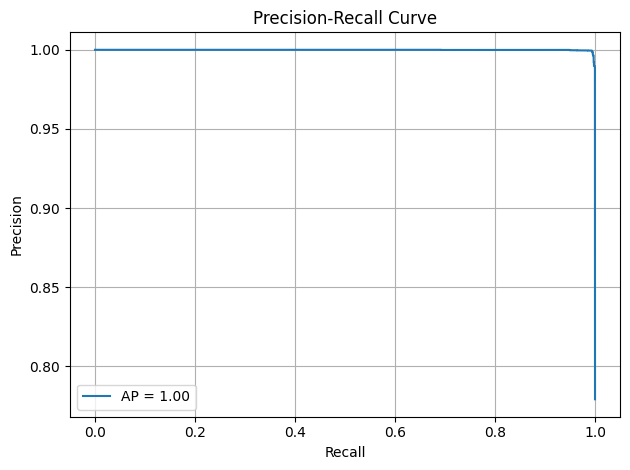

In [31]:
display_metrics(y_test['label'], predictions_rfc['label'], "label Prediction",predictions_rfc["y_proba"])




--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.967649  0.991181  0.979274   3742.0
1   0.718486  0.892223  0.795984   3999.0
2   0.769847  0.911292  0.834619   3799.0
3   0.699590  0.897571  0.786310   3993.0
4   0.000000  0.000000  0.000000    208.0
5   0.992553  0.966936  0.979577   8408.0
6   0.951592  0.752266  0.840270   3972.0
7   0.967138  0.788938  0.868996   2947.0
8   0.643798  0.940750  0.764449   4000.0
9   1.000000  0.031715  0.061479   3027.0

📊 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


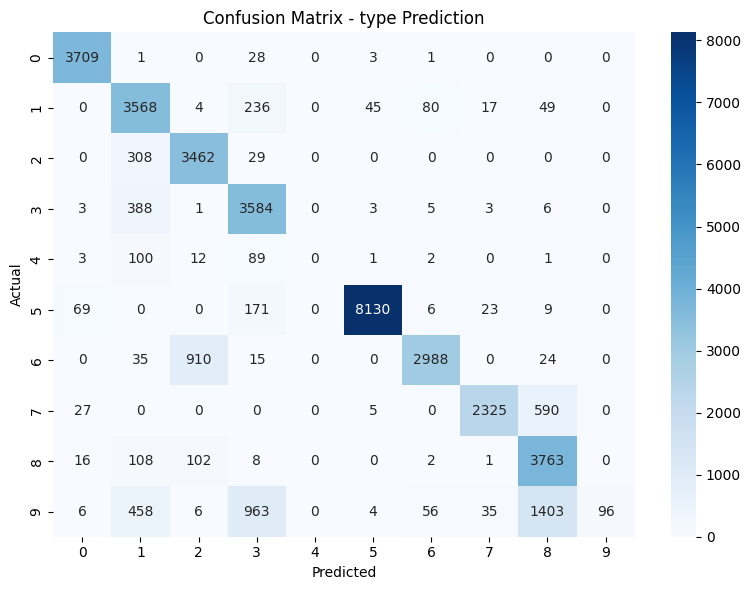


✅ Accuracy: 0.8302
✅ Weighted F1 Score: 0.8016
✅ Macro F1 Score: 0.6911
✅ Macro Precision: 0.7711
✅ Macro Recall: 0.7173
❌ Hamming Loss: 0.169839


In [32]:
display_metrics(y_test['type'], predictions_rfc['type'], "type Prediction")


XGB graddient boosting


In [33]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["label"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:49:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999762  0.999881  0.999822   8408.0
1   0.999966  0.999933  0.999949  29687.0

📊 Confusion Matrix:


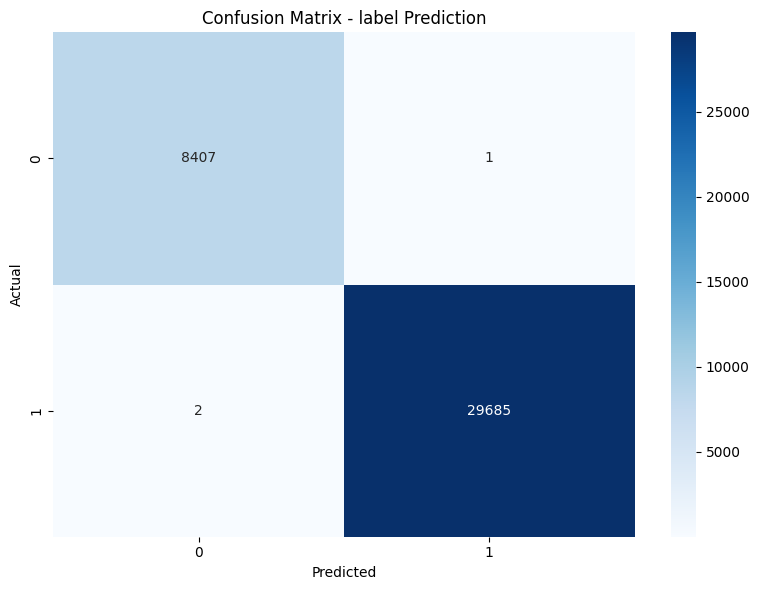


✅ Accuracy: 0.9999
✅ Weighted F1 Score: 0.9999
✅ Macro F1 Score: 0.9999
✅ Macro Precision: 0.9999
✅ Macro Recall: 0.9999
❌ Hamming Loss: 0.000079
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


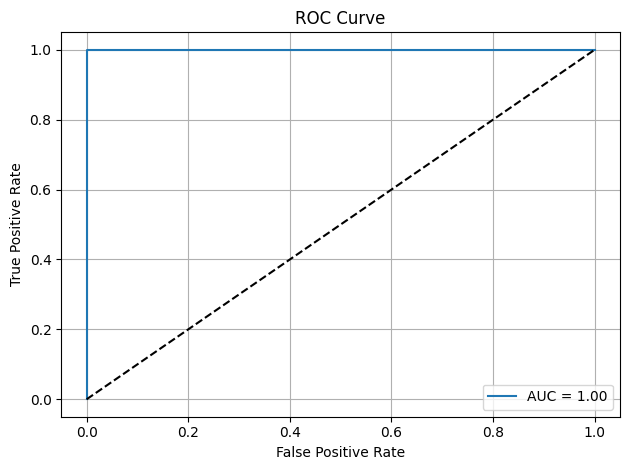

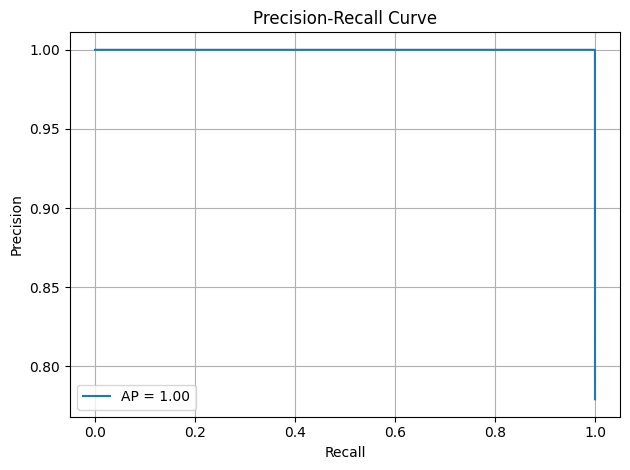

In [34]:
display_metrics(y_test['label'], y_pred_xgb, "label Prediction",y_proba)


In [35]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["type"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:49:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  1.000000  1.000000   3742.0
1   0.995243  0.993998  0.994620   3999.0
2   0.994988  0.992893  0.993939   3799.0
3   0.990991  0.991736  0.991363   3993.0
4   0.906103  0.927885  0.916865    208.0
5   0.999762  0.999762  0.999762   8408.0
6   0.995962  0.993454  0.994706   3972.0
7   0.999661  1.000000  0.999830   2947.0
8   0.992030  0.995750  0.993886   4000.0
9   1.000000  0.999670  0.999835   3027.0

📊 Confusion Matrix:


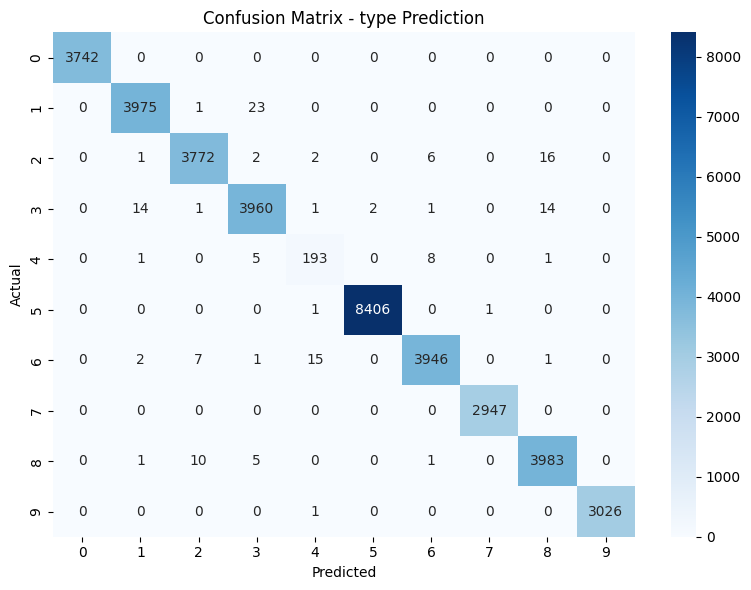


✅ Accuracy: 0.9962
✅ Weighted F1 Score: 0.9962
✅ Macro F1 Score: 0.9885
✅ Macro Precision: 0.9875
✅ Macro Recall: 0.9895
❌ Hamming Loss: 0.003806


In [36]:
display_metrics(y_test['type'], y_pred_xgb, "type Prediction")

Logistic Regression


In [37]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["label"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- label Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.971330  0.975143  0.973233   8408.0
1   0.992952  0.991848  0.992400  29687.0

📊 Confusion Matrix:


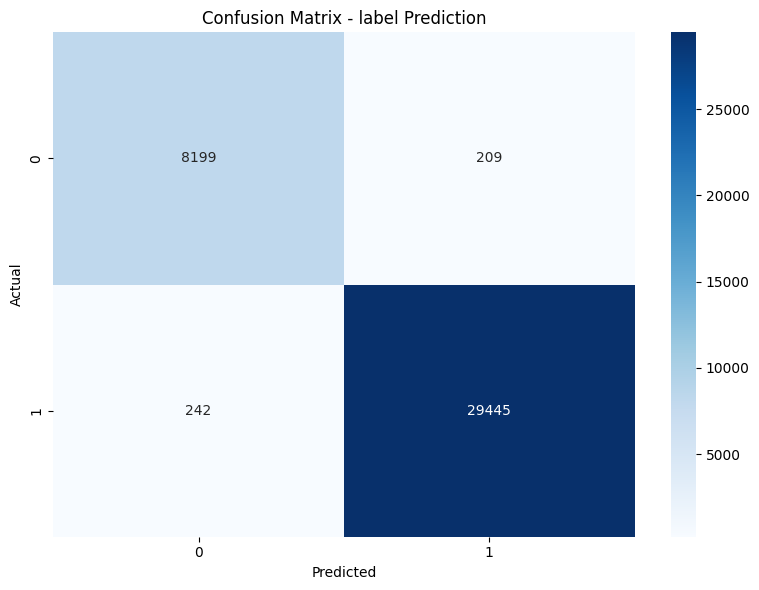


✅ Accuracy: 0.9882
✅ Weighted F1 Score: 0.9882
✅ Macro F1 Score: 0.9828
✅ Macro Precision: 0.9821
✅ Macro Recall: 0.9835
❌ Hamming Loss: 0.011839
📈 ROC AUC Score: 0.9912
📈 PR AUC Score: 0.9902


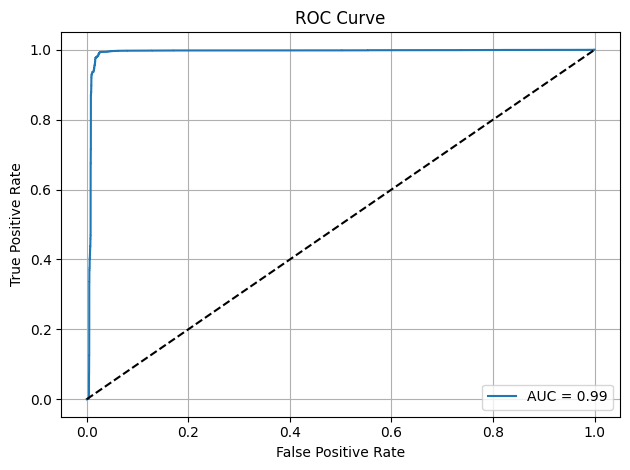

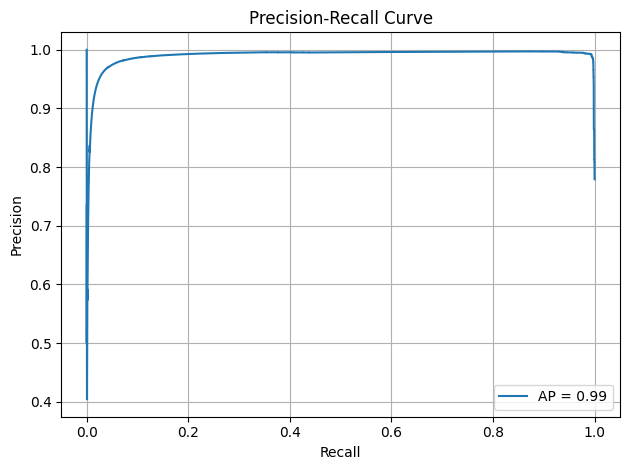

In [38]:
display_metrics(y_test['label'], y_pred_logreg, "label Prediction",y_proba)


In [39]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["type"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)



--- type Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.933048  0.990647  0.960985   3742.0
1   0.792966  0.896474  0.841549   3999.0
2   0.939673  0.938931  0.939302   3799.0
3   0.721146  0.643125  0.679905   3993.0
4   0.725000  0.139423  0.233871    208.0
5   0.962993  0.984182  0.973472   8408.0
6   0.706424  0.753021  0.728979   3972.0
7   0.899445  0.825585  0.860934   2947.0
8   0.954093  0.862500  0.905987   4000.0
9   0.804647  0.812355  0.808483   3027.0

📊 Confusion Matrix:


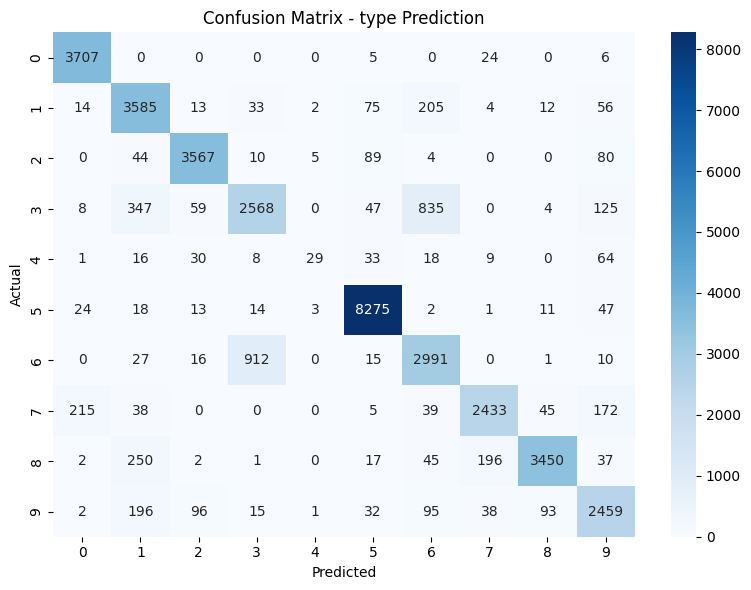


✅ Accuracy: 0.8679
✅ Weighted F1 Score: 0.8658
✅ Macro F1 Score: 0.7933
✅ Macro Precision: 0.8439
✅ Macro Recall: 0.7846
❌ Hamming Loss: 0.132065


In [40]:
display_metrics(y_test['type'], y_pred_logreg, "type Prediction")

Stacked Model

In [41]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(class_weight="balanced")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=200,class_weight="balanced")


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=-1
)


stacked.fit(X_train, y_train["label"])



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None,...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced'))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=200,
                                                      multi_class='multinomial'),
                   n_jobs=-1)


--- label ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999762  0.999881  0.999822   8408.0
1   0.999966  0.999933  0.999949  29687.0

📊 Confusion Matrix:


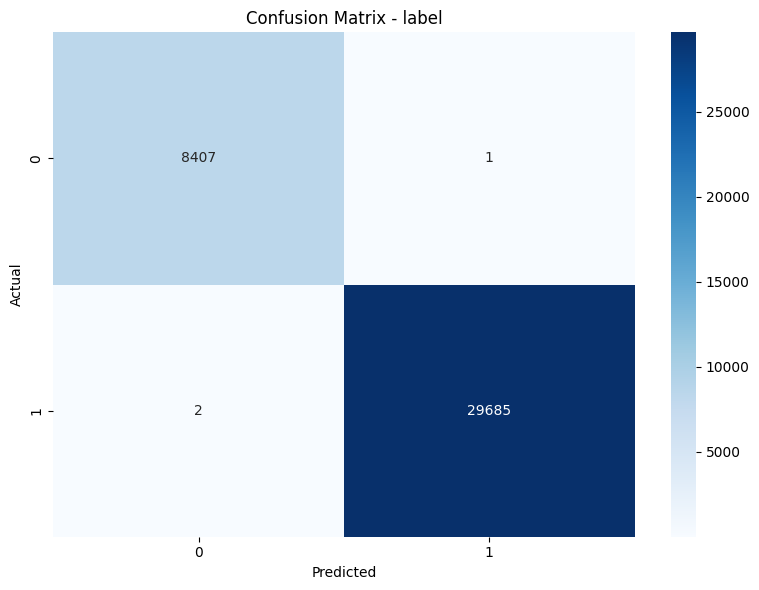


✅ Accuracy: 0.9999
✅ Weighted F1 Score: 0.9999
✅ Macro F1 Score: 0.9999
✅ Macro Precision: 0.9999
✅ Macro Recall: 0.9999
❌ Hamming Loss: 0.000079
📈 ROC AUC Score: 1.0000
📈 PR AUC Score: 1.0000


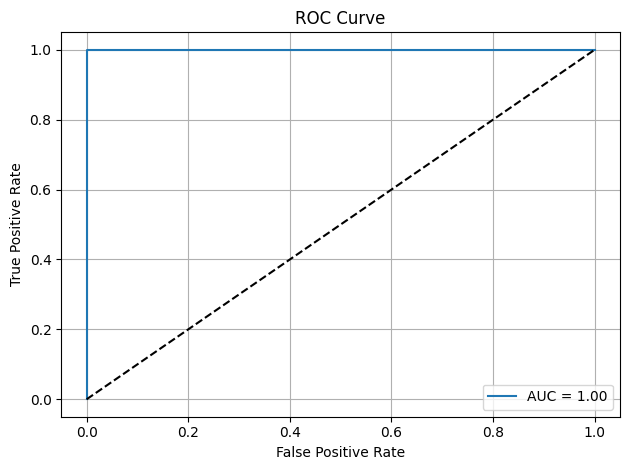

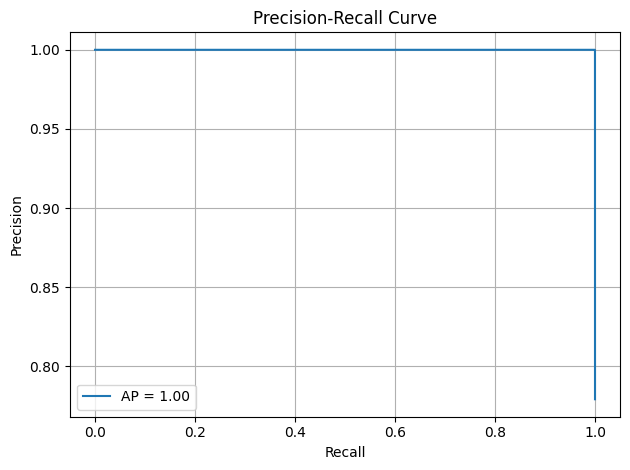

In [42]:
y_pred_attack = stacked.predict(X_test)
y_proba = stacked.predict_proba(X_test)[:, 1]
display_metrics(y_test["label"], y_pred_attack,"label",y_proba)

In [43]:
del y_proba,stacked
gc.collect()

59622

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:52:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:53:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:54:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:54:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'mult


--- type ---

📋 Classification Report:
   precision    recall  f1-score  support
0   1.000000  1.000000  1.000000   3742.0
1   0.995235  0.992248  0.993739   3999.0
2   0.994462  0.992630  0.993545   3799.0
3   0.989245  0.990483  0.989864   3993.0
4   0.836066  0.980769  0.902655    208.0
5   0.999762  0.999881  0.999822   8408.0
6   0.999239  0.991692  0.995451   3972.0
7   1.000000  1.000000  1.000000   2947.0
8   0.992513  0.994250  0.993381   4000.0
9   1.000000  1.000000  1.000000   3027.0

📊 Confusion Matrix:


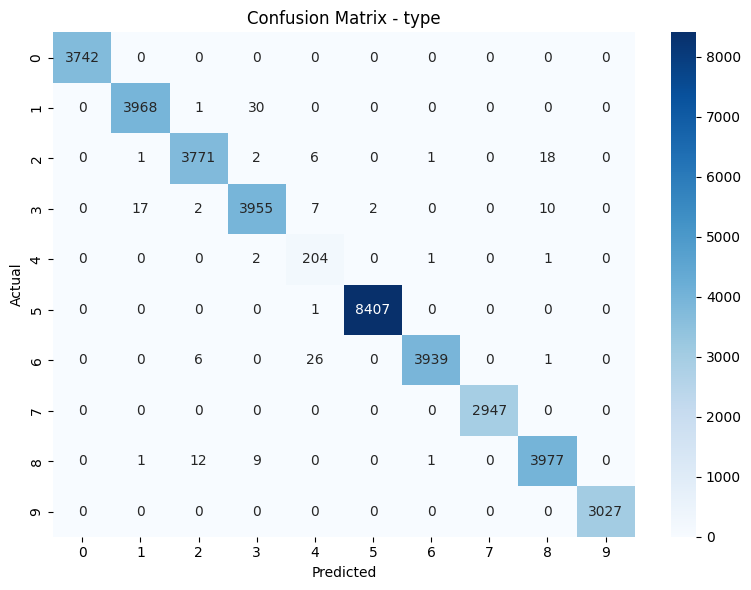


✅ Accuracy: 0.9959
✅ Weighted F1 Score: 0.9959
✅ Macro F1 Score: 0.9868
✅ Macro Precision: 0.9807
✅ Macro Recall: 0.9942
❌ Hamming Loss: 0.004148


In [44]:

stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=cv,
    passthrough=False,
    n_jobs=1
)
X_cat = np.concatenate([X_train, y_train["label"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["type"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)

y_pred_category = stacked.predict(X_cat_test)
display_metrics(y_test["type"], y_pred_category,title="type")

